<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lasciate ogne speranza, voi ch'intrate**

This is a research scratchpad; it's not designed to be read but rather evolved to test ideas. Please reach out if you'd like a guided tour. 



In [2]:
import itertools
import os

import numpy as np
pi = np.pi

!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html -U

import torch as T
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator
from scipy.linalg import toeplitz
from scipy.optimize import minimize_scalar
from scipy.ndimage import rotate
from google.colab import output
!pip install torchdiffeq
!pip install --quiet tensorfont
!pip install --quiet fonttools
!pip install --quiet --upgrade fontParts
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
#!pip install --quiet --upgrade anisotropic-distance-transform
import fontParts
import extractor
import defcon
from torchdiffeq import odeint_adjoint as odeint
#import adt
from ufo2ft import compileOTF

from tensorfont import Font

dev = T.device('cuda' if T.cuda.is_available() else 'cpu')
print("✓ Dependencies imported.")

Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
     |████████████████████████████████| 811.7MB 22kB/s 
     |████████████████████████████████| 17.3MB 1.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 839kB 9.2MB/s 
     |████████████████████████████████| 4.6MB 19.3MB/s 
     |████████████████████████████████| 890kB 57.6MB/s 
     |████████████████████████████████| 163kB 8.1MB/s 
     |████████████████████████████████| 235kB 12.4MB/s 
     |████████████████████████████████| 133kB 10.3MB/s 
     |████████████████████████████████| 133kB 15.8MB/s 
     |████████████████████████████████| 430kB 16.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████

In [3]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


In [4]:
glyph_char_list = "abcdefghijklmnopqrstuvwxyz"
glyph_char_list = "bdghijlmxnopqu" # straight letters only
glyph_char_list = "abgjqrstxc"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"
#glyph_char_list = "axcy"

# ==== Create Font ====
factor = 1.0 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = int(f.full_height_px)
box_width = int(161 * factor) # 121
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)
pi = np.float32(np.pi)

batch_size = 1
sample_distance_deltas = [-2, 0, 3]
sample_distance_factors = [.8, 1., 2.0]
n_sample_distances = len(sample_distance_deltas)

n_v1_scales = 10
n_b_scales = 1
n_v1_orientations = 8
n_v4_scales = 8
n_g_scales = n_v1_scales

# ==== Load glyph images ====

def get_glyph_image(glyph_char):
    """Returns a np.array of shape [box_height, box_width] containing the glyph at the center."""
    return f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

def get_glyph_ink_width(glyph_char):
    """Returns the width of the rendered glyph in pixels."""
    return f.glyph(glyph_char).ink_width

glyph_images = {c: get_glyph_image(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs rendered.", flush=True)
glyph_ink_widths = {c: get_glyph_ink_width(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs measured.", flush=True)

100%|██████████| 10/10 [00:00<00:00, 816.55it/s]

Box size: 80 × 161
  ✓ 10 glyphs rendered.



100%|██████████| 10/10 [00:00<00:00, 15346.89it/s]

  ✓ 10 glyphs measured.


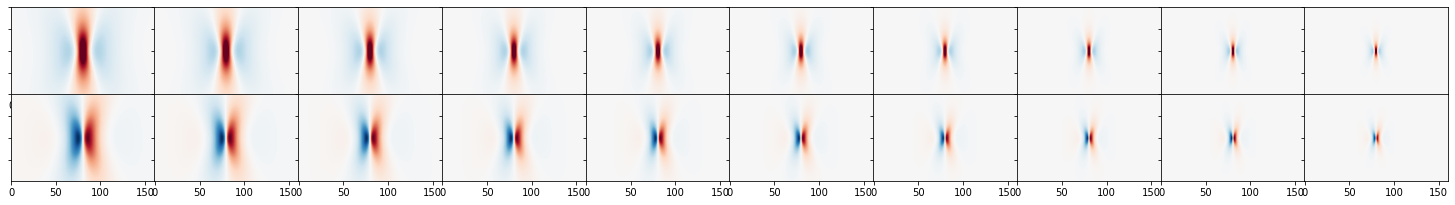

In [5]:
def get_sigmas(skip_scales=0):
    sigmas = []
    min_sigma = 1.9 # the bigger this is, the smaller the extent of the largest filter
    factor = 1.18  # the bigger this is, the more decay (so the smallest filter becomes even smaller)
    for s in range(n_v1_scales):
        sigmas.append(min_sigma * factor ** s)
    return T.tensor(sigmas)

def get_v1_filter_bank(skip_scales, display_filters=False, display_fft=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = T.tensor([[ np.cos(pi*oi/n_v1_orientations), np.sin(pi*oi/n_v1_orientations)],
                                [-np.sin(pi*oi/n_v1_orientations), np.cos(pi*oi/n_v1_orientations)]], dtype=T.float32)
        hh = box_height # / 2
        bw = box_width # / 2
        y, x = T.meshgrid(T.arange(-hh, hh), T.arange(-bw, bw))
        y = y + 0.05 # 0 if box_height % 2 == 0 else 0.5
        x = x + 0.05 # 0 if box_width % 2 == 0 else 0.5
        return T.einsum('ji, mni -> jmn', rotation, T.dstack([x, y]))

    bx, by = rotated_mgrid(0)
    unit_freqs = T.sqrt((bx / box_width)**2+(by/box_height)**2)
    unit_freqs[box_height, box_width] = 1.
    lowpassfilter = 1.0 / (1.0 + (unit_freqs / 0.9)**20)

    bandwidth = 0.75
    def get_filter_log_gabor(s, theta):
        x, y = rotated_mgrid(0)

        x = x * box_height / box_width
        # In this case, we will create the filter directly in the frequency domain.
        freqs = T.sqrt(x**2+y**2)
        freqs[box_height, box_width] = 1.
        target_freq = s
        freq_ring = T.exp(-(T.log(unit_freqs * box_height / target_freq))**2) / (2 * np.log(bandwidth)**2)
        freq_ring[box_height, box_width] = 0

        # Remove the corners of the FFT by passing through a large circle with round edges
        freq_ring *= lowpassfilter

        # Now for the angular filter, we can use a von Mises function. We only want this to go around one side, only on the positive real.
        angle = T.atan2(y, x)
        angle = T.where(angle<0 , 2*pi+angle, angle)
        k = 8
        angular_filter = T.exp(k * T.cos(angle - theta*pi/n_v1_orientations)) / (2*pi*np.i0(k))

        real_filter = freq_ring * angular_filter

        # We want the same energy in every filter. How do we achieve this? We want to take the area that it covers in the FFT and make the max equal to one.
        return T.fft.ifftshift(-real_filter + 0j)

    filter_bank = T.zeros((n_v1_scales, n_v1_orientations, 2*box_height, 2*box_width), dtype=T.complex64)

    if display_filters:
        sizediv = 50
        #fig, ax = plt.subplots(nrows=n_v1_scales*2, ncols=n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, box_height * n_v1_scales * 2 / sizediv))
        fig, ax = plt.subplots(2, n_v1_scales, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, 2*box_height / sizediv))

    sigmas = get_sigmas()
    totalfilter = 0
    for s in range(n_v1_scales):
        sigma = sigmas[s]
        for o in range(n_v1_orientations):
            f = get_filter_log_gabor(sigma, o)
            if display_filters and o == 0:
                mx = T.max(T.abs(T.imag(T.fft.ifft2(f))))
                ax[0,s].imshow(T.real(T.fft.fftshift(T.fft.ifft2(f)))[int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], cmap="RdBu", vmin=-mx, vmax=mx)
                ax[0,s].set_aspect("auto")
                ax[0,s].set_yticklabels([])
                ax[1,s].imshow(T.imag(T.fft.fftshift(T.fft.ifft2(f)))[int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                      int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], cmap="RdBu", vmin=-mx, vmax=mx)
                ax[1,s].set_aspect("auto")
                ax[1,s].set_yticklabels([])
            if display_fft:
                totalfilter += T.fft.fftshift(f)
            filter_bank[s, o, :, :] = f

    if display_filters:
        plt.show()
    if display_fft:
        plt.imshow(T.real(totalfilter))
        plt.colorbar()
        plt.show()
        plt.imshow(T.imag(totalfilter))
        plt.colorbar()
        plt.show()

    return filter_bank

filter_bank = get_v1_filter_bank(0, display_filters=True, display_fft=False)


def apply_filter_bank(input_image, filter_bank, invert=False):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    fbs = filter_bank.shape[-2:]
    if invert:
        bsohwd_input_image = input_image[None, None, :, :, :, :]
        input_in_freqdomain = T.fft.fft2(bsohwd_input_image, s=fbs)
        padded_result = T.fft.ifft2(T.sum(input_in_freqdomain, dim=[2, 3]))
        return padded_result[0, 0, :box_height, :box_width]
    else:
        bdsohw_input_image = input_image[None, None, None, None, :, :]
        input_in_freqdomain = T.fft.fft2(T.tensor(np.array(bdsohw_input_image) + 0j, dtype=T.complex64), s=fbs)
        padded_result = T.fft.ifft2(input_in_freqdomain * filter_bank[None, None, :, :, :, :])
        return padded_result[0, 0, :, :, :box_height, :box_width]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


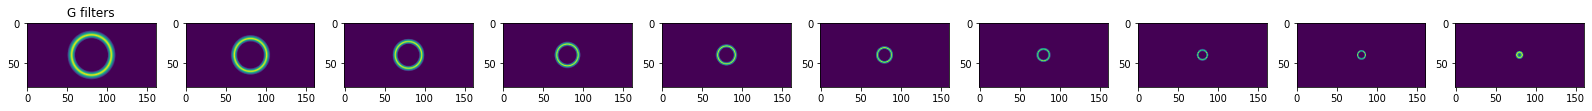

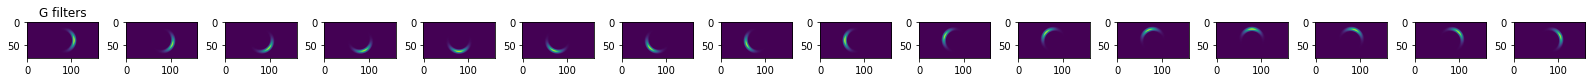

In [16]:
class G_filters(T.nn.Module):
    """
    Creates the annular G-cell filters, one set for each phase.
    Returns: <s, o, p, h, w>
    """
    def __init__(self):
        super().__init__()

        self.factor = T.tensor(0.4/33.).to(dev)

        # adjust until factor*base**(n_g_scales+1) = box_height / box_width
        # so n_g_scales + 1 = log(box_height / (box_width * factor)) / n_g_scales + 1 = log(base)

        self.base = T.tensor(np.exp(np.log(0.7*box_height / (2*box_width * self.factor.cpu())) / (n_g_scales + 3))).to(dev)


        self.u, self.v = T.meshgrid(T.arange(-box_height, box_height, dtype=T.float32),
                          T.arange(-box_width, box_width, dtype=T.float32))
        self.u = self.u / (2*box_width)
        self.v = self.v / (2*box_width)
        self.r = T.sqrt(self.u**2 + self.v**2).to(dev)
        self.bp_angle_masks, self.bn_angle_masks = self.make_angle_masks()

    def make_angle_masks(self):
        angle = T.atan2(self.u, self.v)[None, None, :, :] # <o, c, h, w>
        angles = T.arange(n_v1_orientations, dtype=T.float32)[:, None, None, None]/n_v1_orientations
        
        # Uses von-Mises distribution (via Bessel function)
        angle_mask_widths = T.tensor([4.])
        bp_angle_masks = T.exp(-angle_mask_widths * T.cos(angle - pi - pi * angles)) / (2*pi*np.i0(angle_mask_widths))
        bn_angle_masks = T.exp(-angle_mask_widths * T.cos(angle - pi * angles)) / (2*pi*np.i0(angle_mask_widths))

        return bp_angle_masks, bn_angle_masks

    def make_radial_masks(self):
        rs = T.cat([T.tensor([0]).to(dev), self.factor * self.base ** T.arange(n_g_scales + 1).to(dev)]) # makes it <c=8, p=4>

        radial_masks = T.zeros((1, n_g_scales, 2*box_height, 2*box_width))

        for i in range(n_g_scales):
            a, c, b = rs[i], rs[i + 1], rs[i + 2]
            updiagonal = 2*(self.r - a) / ((b-a)*(c-a))
            downdiagonal = 2*(b-self.r) / ((b-a)*(b-c))
            radial_masks[:, i, :, :] = F.relu(T.minimum(updiagonal, downdiagonal))[None, :, :]  # make it <o, c, p, h, w>
    
        return T.flip(radial_masks, dims=[1])  # We actually want to start with the biggest radius, because the first V1 filter is the largest, too

    def forward(self): # Returns masks of shape <o, c, h, w>
        #print("G params", [p.T.detach().cpu().numpy() for p in self.parameters()])

        radial_masks = self.make_radial_masks()

        bp_masks = radial_masks * self.bp_angle_masks
        bn_masks = radial_masks * self.bn_angle_masks
    
        # Each bp/bn_mask fragment should add up to exactly one.
        eps = 1e-10
        bp_masks_normed = 4*bp_masks / (eps + T.sum(F.relu(bp_masks), (0, -2, -1), keepdims=True))
        bn_masks_normed = 4*bn_masks / (eps + T.sum(F.relu(bn_masks), (0, -2, -1), keepdims=True))
    
        return T.einsum("ochw->cohw", T.clip(T.cat([bp_masks_normed, bn_masks_normed], axis=0), -1e12, 1e12))

def test_G_filters():
    gf = G_filters().to(dev)()  # create and run, in one go

    fig, ax = plt.subplots(1, n_g_scales, figsize=[22, 9], constrained_layout=True)
    ax[0].set_title("G filters")
    for i in range(n_g_scales):
        ax[i].imshow(np.sum(gf.detach().cpu().numpy()[i, :,   
                                        int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], (0)))
    plt.show()

    fig, ax = plt.subplots(1, 2*n_v1_orientations, figsize=[22, 9], constrained_layout=True)
    ax[0].set_title("G filters")
    for i in range(2*n_v1_orientations):
        ax[i].imshow(gf.detach().cpu().numpy()[0, i,   
                                        int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))])
    plt.show()

test_G_filters()

In [17]:
class B_G_Differential(T.nn.Module):
    def __init__(self):
        super().__init__()

        #self.G_input_weight = T.nn.Parameter(T.tensor([1.0] * n_v1_scales, requires_grad=False)[:, None, None, None])
        #self.G_output_weight = T.nn.Parameter(T.tensor([5.0] * n_v1_scales, requires_grad=False)[:, None, None, None, None])
        #self.G_decay_rate = T.nn.Parameter(T.tensor([1.0] * n_v1_scales, requires_grad=False)[:, None, None, None])
        #self.B_inhibition_weight = T.nn.Parameter(T.tensor([1.0] * n_v1_scales, requires_grad=False)[:, None, None, None, None])
        #self.B_decay_rate = T.nn.Parameter(T.tensor([20.0] * n_v1_scales, requires_grad=False)[:, None, None, None, None])

        self.G_input_weight = T.tensor([1.0] * n_v1_scales).to(dev)[:, None, None, None]
        self.G_output_weight = T.tensor([5.0] * n_v1_scales).to(dev)[:, None, None, None, None]
        self.G_decay_rate = T.tensor([1.0] * n_v1_scales).to(dev)[:, None, None, None]
        self.B_inhibition_weight = T.tensor([1.0] * n_v1_scales).to(dev)[:, None, None, None, None]
        self.B_decay_rate = T.tensor([20.0] * n_v1_scales).to(dev)[:, None, None, None, None]

    def conv_b_to_g(self, b, g_filters_fft):
        """Projection upwards from B to G cells. <bd sohw> → <bd shw>"""

        b_fft = T.fft.fft2(b + 0j, s=g_filters_fft.shape[-2:])
        result = T.real(T.fft.ifft2(b_fft * g_filters_fft))[..., :b.shape[-2], :b.shape[-1]]
        return T.sum(result, dim=[-3]) # sum over all incoming orientations

    def get_g_inputs(self, b, g_filters_fft):
        """Collect inputs from B cells for all four phases. <bd sophw> → <bd sphw>"""

        gi0 = self.conv_b_to_g(b[..., 0, :, :], g_filters_fft) # wbw
        gi1 = self.conv_b_to_g(T.cat([b[..., :n_v1_orientations, 1, :, :], b[..., n_v1_orientations:, 3, :, :]], dim=-3), g_filters_fft)  # bw
        gi2 = self.conv_b_to_g(b[..., 2, :, :], g_filters_fft) # bwb
        gi3 = self.conv_b_to_g(T.cat([b[..., :n_v1_orientations, 3, :, :], b[..., n_v1_orientations:, 1, :, :]], dim=-3), g_filters_fft)  # wb

        return T.stack([gi0, gi1, gi2, gi3], dim=-3) # stack phases together

    def conv_g_to_b(self, g, g_filters_inverse_fft):
        """Projection downwards from G to B cells. <bd sphw> → <bd sohw>"""

        g_fft = T.fft.fft2(g, s=g_filters_inverse_fft.shape[-2:])[..., None, :, :, :]  # insert empty o dimension for <bd sophw>
        result = T.real(T.fft.ifft2(g_fft * g_filters_inverse_fft[..., None, :, :]))[..., :g.shape[-2], :g.shape[-1]]  # does this broadcast correctly, aligned at the end? hopefully ...
        return result  # <bd sophw>, where o is doubled up and will need to be split up

    def get_b_amplification(self, g, g_filters_inverse_fft):
        """Collect inputs from G to B cells for all four phases. <bd sphw> → <bd sophw>"""
        
        projections = self.conv_g_to_b(g, g_filters_inverse_fft)

        # Now we need to split these projections <bd sophw> back into the phases they came from, to get the gain factors for <bd sophw> 
        # This works naturally for phases 0 and 2, but for 1 and 3 it will be wrong.
        p0 = projections[..., 0, :, :]
        p1 = T.cat([projections[..., :n_v1_orientations, 1, :, :], projections[..., n_v1_orientations:, 3, :, :]], dim=-3)
        p2 = projections[..., 2, :, :]
        p3 = T.cat([projections[..., :n_v1_orientations, 3, :, :], projections[..., n_v1_orientations:, 1, :, :]], dim=-3)

        return T.stack([p0, p1, p2, p3], dim=-3) 

    def get_b_inhibition(self, b):
        """Find the opposites of the respective B cells."""

        i0 = b[..., 2, :, :]  # <bd sophw>
        i1 = T.cat([b[..., :n_v1_orientations, 3, :, :], b[..., n_v1_orientations:, 1, :, :]], dim=-3)
        i2 = b[..., 0, :, :]
        i3 = T.cat([b[..., :n_v1_orientations, 1, :, :], b[..., n_v1_orientations:, 3, :, :]], dim=-3)

        return T.stack([i0, i1, i2, i3], dim=-3)  # <bd sophw>

    def forward(self, t, state):
        # b: <bd sophw>  p = phase (4), and o=2*n_v1_orientations
        # g: <bd sphw>  p = phase (4)

        # g_filters, g_filters_fft, g_filters_inverse_fft, input_b_response

        (b, g,
         g_filters_fft_real,
         g_filters_fft_imag,
         g_filters_inverse_fft_real,
         g_filters_inverse_fft_imag,
         input_b_response) = state  

        g_filters_fft = g_filters_fft_real + g_filters_fft_imag * 1j
        g_filters_inverse_fft = g_filters_inverse_fft_real + g_filters_inverse_fft_imag * 1j

        # So, what are the relationships between the respective neurons here?
        # First, we want to compute the respective G cell excitation caused by the G cells

        # compute g_inputs
        # First, the even part (rp=Mexican hat, rn=inverse Mexican hat).
        # Each G cell takes either from 
        g_inputs = self.get_g_inputs(b, g_filters_fft)  # <bd sphw>
        d_g = -g*self.G_decay_rate + F.relu(g_inputs * self.G_input_weight)
        # Then, we project down the G strength onto the B cells, and we amplify them

        b_amplification = self.get_b_amplification(g, g_filters_inverse_fft)

        # compute b_inhibition
        b_inhibition = self.get_b_inhibition(b)

        # compute b_amplification
        d_b = (
            -b * self.B_decay_rate
            + F.relu( 
                input_b_response*(b_amplification*self.G_output_weight + 1.)
                -b_inhibition*self.B_inhibition_weight 
            )
        )

        #print("Differntial params", [p.T.detach().cpu().numpy() for p in self.parameters()])

        return (d_b, d_g, T.zeros_like(g_filters_fft_real).to(dev),
                T.zeros_like(g_filters_fft_imag).to(dev),
                T.zeros_like(g_filters_inverse_fft_imag).to(dev),
                T.zeros_like(g_filters_inverse_fft_imag).to(dev),
                T.zeros_like(input_b_response).to(dev))

In [30]:
class B_Reward_Coefficients(T.nn.Module):
    def __init__(self):
        super().__init__()

        atemplate = T.ones((n_v1_scales, 4, 1, 1))
        atemplate[3:, ...] = 0.
        atemplate[:2, ...] = 0.

        self.gain_a = T.nn.Parameter(atemplate)  # <sphw>
        self.gain_b = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.gain_c = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.gain_d = T.nn.Parameter(T.zeros((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.loss_a = T.nn.Parameter(atemplate)  # <sphw>
        self.loss_b = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.loss_c = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.loss_d = T.nn.Parameter(T.zeros((n_v1_scales, 4, 1, 1)))  # <sphw>

    def conv_g_to_b(self, g, g_filters_inverse_fft):
        # apply the ring convolution to the pairing of this <bd sphw> to make two <bd sohw>
        # by applying the ring segments in reverse
        g_fft = T.fft.fft2(g, s=g_filters_inverse_fft.shape[-2:])[..., None, :, :, :]  # insert empty o dimension for <bd sophw>
        result = T.real(T.fft.ifft2(g_fft * g_filters_inverse_fft[..., None, :, :]))[..., :g.shape[-2], :g.shape[-1]]  # does this broadcast correctly, aligned at the end? hopefully ...

        return result  # <bd sophw>, where o is double, ... but we need to split them up

    def get_b_gradient(self, g, g_filters_inverse_fft):
        # we have <bd sphw> and we want to get <bd sopchw>. So this is exactly the opposite as the above.
        # we get back <bd sophw>, and we would like 
        projections = self.conv_g_to_b(g, g_filters_inverse_fft)

        p0 = projections[..., :n_v1_orientations, 0, :, :] + projections[..., n_v1_orientations:, 0, :, :]
        p1 = projections[..., :n_v1_orientations, 3, :, :] + projections[..., n_v1_orientations:, 1, :, :]
        p2 = projections[..., :n_v1_orientations, 2, :, :] + projections[..., n_v1_orientations:, 2, :, :]
        p3 = projections[..., :n_v1_orientations, 1, :, :] + projections[..., n_v1_orientations:, 3, :, :]

        return T.stack([p0, p1, p2, p3], dim=-3)  # <bd sophw>

    def forward(self, inputs):
        (g, g_filters_inverse_fft, plot) = inputs

        g_gain_penalties = (1e-5 + F.relu(g * self.gain_a)) ** F.softplus(self.gain_b) * T.exp(-g**2 / (1e-5 + self.gain_c**2)) + F.softplus(self.gain_d, 1000)
        g_loss_penalties = (1e-5 + F.relu(g * self.loss_a)) ** F.softplus(self.loss_b) * T.exp(-g**2 / (1e-5 + self.loss_c**2)) + F.softplus(self.loss_d, 1000)

        if plot:

            gainpeak = (T.sqrt(T.mean(self.gain_b)) * T.mean(self.gain_c) / np.sqrt(2.)).detach().cpu().numpy()
            print("mean gain peak at", gainpeak)
            losspeak = (T.sqrt(T.mean(self.loss_b)) * T.mean(self.loss_c) / np.sqrt(2.)).detach().cpu().numpy()
            print("mean loss peak at", losspeak)

            fig, ax = plt.subplots(2, 4)
            ax[0, 0].imshow(self.gain_a.detach().cpu().numpy()[:, :, 0, 0])
            ax[0, 1].imshow(F.softplus(self.gain_b[:, :, 0, 0]).detach().cpu().numpy())
            ax[0, 2].imshow(self.gain_c.detach().cpu().numpy()[:, :, 0, 0])
            ax[0, 3].imshow(F.softplus(self.gain_d, 1000).detach().cpu().numpy()[:, :, 0, 0])
            ax[1, 0].imshow(self.loss_a.detach().cpu().numpy()[:, :, 0, 0])
            ax[1, 1].imshow(F.softplus(self.loss_b[:, :, 0, 0]).detach().cpu().numpy())
            ax[1, 2].imshow(self.loss_c.detach().cpu().numpy()[:, :, 0, 0])
            ax[1, 3].imshow(F.softplus(self.loss_d, 1000).detach().cpu().numpy()[:, :, 0, 0])
            plt.show()

        b_gain_grads = self.get_b_gradient(g_gain_penalties, g_filters_inverse_fft)  # <bd sophw>, with 8 orientations
        b_loss_grads = self.get_b_gradient(g_loss_penalties, g_filters_inverse_fft)  # <bd sophw>, with 8 orientations

        return (b_gain_grads, b_loss_grads)

In [25]:
class YinYangFit(T.nn.Module):
    def __init__(self, g_filters_inverse_fft):
        super().__init__()

        self.g_filters_inverse_fft = g_filters_inverse_fft
        self.b_reward_coefficients = B_Reward_Coefficients().to(dev)

        self.gains_exps = T.nn.Parameter(T.ones((n_v1_scales, n_v1_orientations, 4, 1, 1)) * 0.7)  # <sphw>
        self.losses_exps = T.nn.Parameter(T.ones((n_v1_scales, n_v1_orientations, 4, 1, 1)) * 0.7) # <sphw>

    def compute_v1_changes(self, p1, p2):
        """Returns the changes to each phase. <bd sohw> → <bd sophw>"""
        def c(m, p):
            gains = F.relu(T.stack([F.relu(T.real(m)) - F.relu(T.real(p)),
                            F.relu(T.imag(m)) - F.relu(T.imag(p)),
                            F.relu(-T.real(m)) - F.relu(-T.real(p)),
                            F.relu(-T.imag(m)) - F.relu(-T.imag(p))], axis=-3))
            
            losses = F.relu(-T.stack([F.relu(T.real(m)) - F.relu(T.real(p)),
                                F.relu(T.imag(m)) - F.relu(T.imag(p)),
                                F.relu(-T.real(m)) - F.relu(-T.real(p)),
                                F.relu(-T.imag(m)) - F.relu(-T.imag(p))], axis=-3))
            
            return gains ** F.softplus(self.gains_exps), losses ** F.softplus(self.losses_exps)

        m = p1 + p2
        return c(m, p1), c(m, p2)

    def forward(self, inputs):
        p1, p2, p1_g, p2_g, plot = inputs

        # Get V1 slopes
        p1_gain_r, p1_loss_r = self.b_reward_coefficients((p1_g, self.g_filters_inverse_fft, plot))
        p2_gain_r, p2_loss_r = self.b_reward_coefficients((p2_g, self.g_filters_inverse_fft, plot))

        # Overlap the two letters, compute increases and reductions in V1
        (gain_1, loss_1), (gain_2, loss_2) = self.compute_v1_changes(p1, p2)


        # Compute the rewards for each letter
        r1 = p1_gain_r * gain_1 - p1_loss_r * loss_1
        r2 = p2_gain_r * gain_2 - p2_loss_r * loss_2

        if plot:
            print("p1g mean and max:", T.mean(p1_g).detach().cpu().numpy(), T.max(p1_g).detach().cpu().numpy())
            print("gain_1 mean and max:", T.mean(gain_1).detach().cpu().numpy(), T.max(gain_1).detach().cpu().numpy())
            print("loss_1 mean and max:", T.mean(loss_1).detach().cpu().numpy(), T.max(loss_1).detach().cpu().numpy())

            # Gain rewards for each phase

            fig, ax = plt.subplots(2, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, 2*box_height / 30))
            ax[0, 0].imshow(T.sum(p1_gain_r[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[0, 1].imshow(T.sum(p1_gain_r[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[0, 2].imshow(T.sum(p1_gain_r[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[0, 3].imshow(T.sum(p1_gain_r[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[1, 0].imshow(T.sum(p2_gain_r[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[1, 1].imshow(T.sum(p2_gain_r[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[1, 2].imshow(T.sum(p2_gain_r[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[1, 3].imshow(T.sum(p2_gain_r[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy())
            plt.show()
            
            fig, ax = plt.subplots(2, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, 2*box_height / 30))
            ax[0, 0].imshow(T.sum(p1_loss_r[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[0, 1].imshow(T.sum(p1_loss_r[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[0, 2].imshow(T.sum(p1_loss_r[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[0, 3].imshow(T.sum(p1_loss_r[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[1, 0].imshow(T.sum(p2_loss_r[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[1, 1].imshow(T.sum(p2_loss_r[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[1, 2].imshow(T.sum(p2_loss_r[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy())
            ax[1, 3].imshow(T.sum(p2_loss_r[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy())
            plt.show()

            # Display the rewards for each letter
            plt.imshow(T.sum(r1[0,1,...], dim=[-5,-4,-3]).detach().cpu().numpy())
            plt.colorbar()
            plt.show()
            plt.imshow(T.sum(r2[0,1,...], dim=[-5,-4,-3]).detach().cpu().numpy())
            plt.colorbar()
            plt.show()
            plt.imshow(T.sum((r1+r2)[0,1,...], dim=[-5,-4,-3]).detach().cpu().numpy())
            plt.colorbar()
            plt.show()

            # Display the exponents
            plt.imshow(F.softplus(self.gains_exps)[:, :, 0, 0, 0].detach().cpu().numpy())
            plt.colorbar()
            plt.title("gains exps (phase 0)")
            plt.show()
            plt.imshow(F.softplus(self.losses_exps)[:, :, 0, 0, 0].detach().cpu().numpy())
            plt.colorbar()
            plt.title("losses exps (phase 0)")
            plt.show()

        # Compute the total rewards for each distance. In: <bd sophw>, out: <bd>
        rt = T.sum(r1 + r2, dim=[-5,-4,-3,-2,-1])

        return rt


In [10]:
def get_pair_translations(char1, char2, distance_deltas, distance_factors=None):
    """Returns two 1D arrays of distances (in pixels) by which the left and right glyph need to be translated (i.e. shifted horizontally)
    in order to place the two glyphs at the desired distances.
    
    Example: distance_deltas = [-2, 0, 2] or distance_factors=[0.7, 1.0, 1.5]
    """

    optimal_distance = int(f.pair_distance(char1, char2) + f.minimum_ink_distance(char1, char2))

    if distance_factors is None:
        if distance_deltas is None:
            raise ValueError("Must provide either distance_deltas or distance_factors")
        
        sample_distances = optimal_distance + np.array(distance_deltas)
    else:
        if distance_deltas is not None:
            raise ValueError("Must provide either distance_deltas or distance_factors, not both")

        sample_distances = optimal_distance * np.array(distance_factors)

    total_width_at_minimum_ink_distance = glyph_ink_widths[char1] + glyph_ink_widths[char2] - f.minimum_ink_distance(char1, char2)
    total_ink_width = glyph_ink_widths[char1] + glyph_ink_widths[char2]
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)

    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)
    
    return (left_translations, right_translations)

#print("  ✓ Pair translations test,", get_pair_translations("x", "a", [-2, 0, 5]))

In [11]:
def apply_translations(input_image, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param image: <sizes, orientations, [phases], height, width>
    @param translations: <len(translations)>
    @output        <len(translations), sizes, orientations, [phases], height, width>
    """

    images = T.tile(input_image[None, ...], [translations.shape[0]] + [1] * len(input_image.shape)) # create len(shifts) channel copies
    fill_constant = 0
    left_pad = np.maximum(0, np.max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right_pad = np.maximum(0, -np.min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = T.zeros(images.shape[:-1] + (left_pad,), dtype=images.dtype).to(dev)
    right_mask = T.zeros(images.shape[:-1] + (right_pad,), dtype=images.dtype).to(dev)
    padded_images = T.cat([left_mask, images, right_mask], dim=-1) # pad on last axis (i.e. width-wise)

    for i, t in enumerate(translations):
        left_x = left_pad - t
        right_x = left_pad - t + input_image.shape[-1]
        images[i, ...] = padded_images[i, ..., left_x:right_x]

    return images

In [12]:
# We will now create a Torch Dataset that provides pairs of letters at various distances.


# Generate G filters
g_filters = G_filters().to(dev)()
g_filters_fft = T.fft.fft2(T.fft.ifftshift(g_filters + 0j, [-2, -1])).to(dev)
g_filters_inverse_fft = T.roll(g_filters_fft, [n_v1_orientations], dims=[-3]).to(dev)

class GlyphPairs(T.utils.data.Dataset):
    def __init__(self, end_time):
        super().__init__()
        # We perform the V1 filtering for all of the glyphs first.

        self.v1_responses = {c: apply_filter_bank(-glyph_images[c], filter_bank, invert=False) for c in tqdm(glyph_char_list)}

        self.b_g_differential = B_G_Differential().to(dev)
        self.end_time = end_time

        self.pg_cache = {}

    def __len__(self):
        # The total number of pairs available
        return len(glyph_char_list) ** 2

    def apply_g_filters(self, image, g_filters_fft, g_filters_inverse_fft):
        b_doubled = T.cat([image] * 2, dim=-3).to(dev)
        b_initial = T.stack([F.relu(T.real(b_doubled)),
                             F.relu(T.imag(b_doubled)),
                             F.relu(-T.real(b_doubled)),
                             F.relu(-T.imag(b_doubled))], axis=-3).to(dev)

        g_initial = T.zeros_like(b_initial[..., 0, :, :, :]).to(dev) # <bd sophw> -> <bd sphw>, delete

        # This is really annoying, but we need to split up the filters into real and imaginary,
        # because of a limitation of odeint.
        initial_state = (b_initial, 
                         g_initial,
                         T.real(g_filters_fft),
                         T.imag(g_filters_fft),
                         T.real(g_filters_inverse_fft),
                         T.imag(g_filters_inverse_fft),
                         b_initial)
        times = T.tensor([0.0, self.end_time]).to(dev)

        # Integrate over a few time steps
        with T.no_grad():
            b_out, g_out, _, _, _, _, _ = odeint(self.b_g_differential, initial_state, times)

        return (b_out[-1, ...], g_out[-1, ...])  # return the final time only

    def __getitem__(self, idx):
        # Convert the idx into first and last letter
        g1 = glyph_char_list[idx // len(glyph_char_list)]
        g2 = glyph_char_list[idx % len(glyph_char_list)]

        i1, i2 = self.v1_responses[g1].to(dev), self.v1_responses[g2].to(dev)
        print("Generating pair", g1, g2, " ...", flush=True)
        #with T.no_grad():
        # Shift the letters accordingly to the necessary pair translations
        (t1, t2) = get_pair_translations(g1, g2, sample_distance_deltas)

        if g1 not in self.pg_cache:
            (i1_b, i1_g) = self.apply_g_filters(i1, g_filters_fft, g_filters_inverse_fft)
            self.pg_cache[g1] = i1_g
        if g2 not in self.pg_cache:
            (i2_b, i2_g) = self.apply_g_filters(i2, g_filters_fft, g_filters_inverse_fft)
            self.pg_cache[g2] = i2_g

        # Return three pairs of complex-valued, horizontally shifted images, <d sohw>
        p1, p2 = apply_translations(i1, t1), apply_translations(i2, t2)

        if False: 
            gi1, gi2 = T.tensor(glyph_images[g1]).to(dev), T.tensor(glyph_images[g2]).to(dev)
            git1, git2 = apply_translations(gi1, t1), apply_translations(gi2, t2)
            fig, ax = plt.subplots(1, 3, figsize=(15,5))
            ax[0].imshow((git1 + git2)[0, :, :].detach().cpu().numpy())
            ax[1].imshow((git1 + git2)[1, :, :].detach().cpu().numpy())
            ax[2].imshow((git1 + git2)[2, :, :].detach().cpu().numpy())
            plt.show()

        pg1, pg2 = apply_translations(self.pg_cache[g1], t1), apply_translations(self.pg_cache[g2], t2)

        label = T.tensor(1, dtype=T.long).to(dev)

        return [g1, g2, p1.to(dev), p2.to(dev), pg1, pg2, label]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


mean gain peak at 0.72407687
mean loss peak at 0.73110056


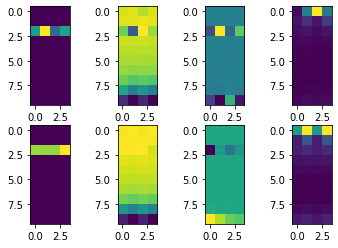

mean gain peak at 0.72407687
mean loss peak at 0.73110056


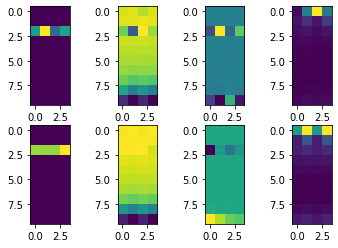

p1g mean and max: 0.0006633286 0.009298142
gain_1 mean and max: 0.019856658 1.859438
loss_1 mean and max: 0.006401539 0.5346604


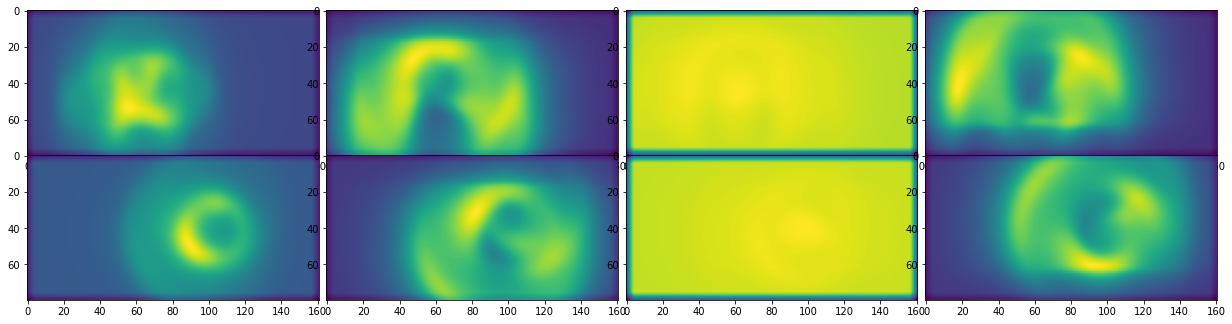

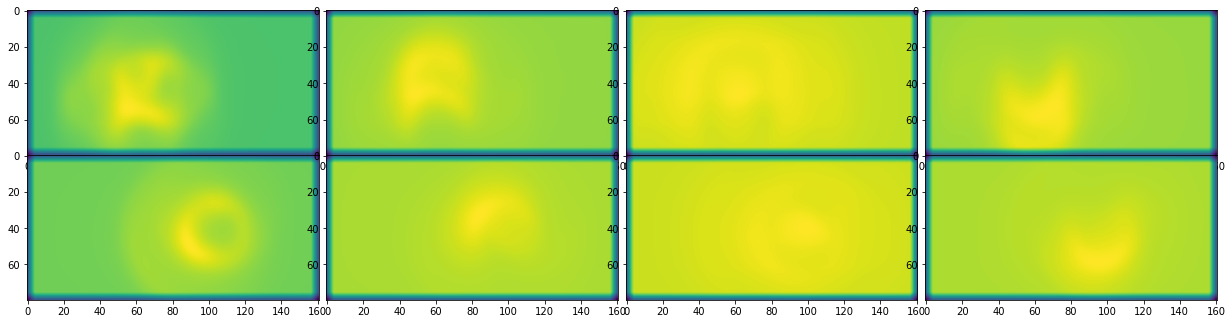

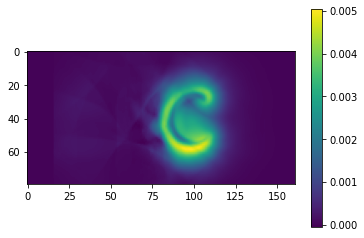

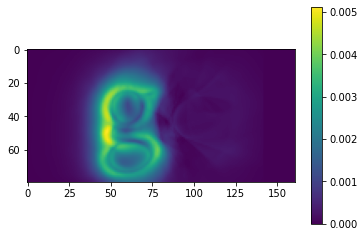

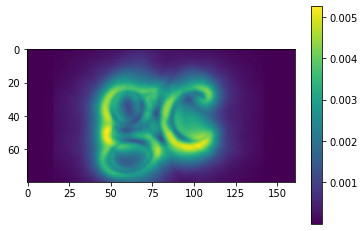

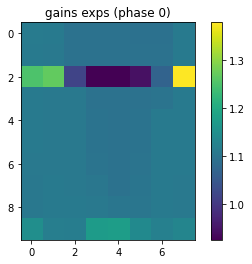

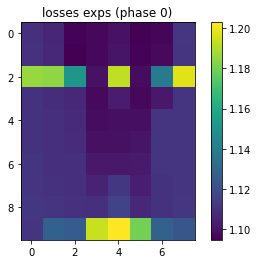

('g',) ('c',) doesn't penalize proximity enough
outputs: [[15.160233 15.149731 14.949657]]
loss: 1.0400038 origs: 0.35345334
memory used: 26.51398191283012


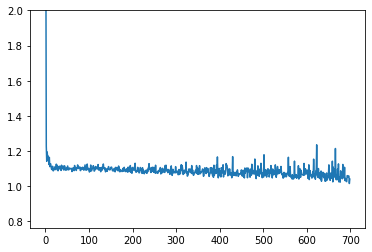

now in epoch 7
Generating pair j s  ...
('j',) ('s',) doesn't reward the gap properly
Generating pair j q  ...
('j',) ('q',) doesn't penalize proximity enough
Generating pair t t  ...
('t',) ('t',) doesn't reward the gap properly
Generating pair s b  ...
Generating pair g t  ...
Generating pair g x  ...
('g',) ('x',) doesn't penalize proximity enough
Generating pair c t  ...
('c',) ('t',) doesn't penalize proximity enough
Generating pair r b  ...
('r',) ('b',) doesn't penalize proximity enough
Generating pair g r  ...
Generating pair g j  ...
('g',) ('j',) doesn't reward the gap properly
Generating pair t q  ...
('t',) ('q',) doesn't penalize proximity enough
Generating pair b j  ...
('b',) ('j',) doesn't penalize proximity enough
Generating pair r a  ...
('r',) ('a',) doesn't penalize proximity enough
Generating pair j c  ...
('j',) ('c',) doesn't reward the gap properly
Generating pair q q  ...
('q',) ('q',) doesn't penalize proximity enough
Generating pair x r  ...
('x',) ('r',) doe

KeyboardInterrupt: ignored

In [31]:
# Train the model

glyph_pairs = GlyphPairs(end_time=0.002)
dataloader = T.utils.data.DataLoader(glyph_pairs, batch_size=1, shuffle=True)

yinyangfit = YinYangFit(g_filters_inverse_fft).to(dev)

criterion = T.nn.CrossEntropyLoss()
optimizer = T.optim.Adam(yinyangfit.parameters(), lr=0.0015)
T.cuda.empty_cache()
losses = []
log_interval = 50
for epoch in range(50):  # loop over the dataset multiple times
    print("now in epoch", epoch)
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        [g1, g2, p1, p2, pg1, pg2, labels] = data

        is_log_interval = (i % log_interval == log_interval - 1)
        if is_log_interval:
            output.clear()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = yinyangfit((p1, p2, pg1, pg2, is_log_interval))
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        od = outputs.detach().cpu().numpy()
        if outputs[0, 0] > outputs[0, 1]:
            print(g1, g2, "doesn't penalize proximity enough")
        elif outputs[0, 2] > outputs[0, 1]:
            print(g1, g2, "doesn't reward the gap properly")

        if is_log_interval:
            print("outputs:", outputs.detach().cpu().numpy(), flush=True)
            print("loss:", loss.detach().cpu().numpy(), "origs:", np.exp(-loss.detach().cpu().numpy()), flush=True)
            print("memory used:", 100 * T.cuda.memory_allocated(0) / T.cuda.get_device_properties(0).total_memory)
        #outputs.grad = None
        #labels.grad = None
        # print statistics
        losses.append(loss.item())
        running_loss += loss.item()

        if is_log_interval:
            plt.plot(losses)
            plt.ylim(top=2.)
            plt.plot([.5] * len(losses))
            plt.show()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    #outputs.detach().cpu()
    #T.cuda.empty_cache()
print('Finished Training')

PATH = './yinyangfit.pth'
T.save(yinyangfit.state_dict(), PATH)





In [ ]:
print("memory used:", 100 * T.cuda.memory_allocated(0) / T.cuda.get_device_properties(0).total_memory)
!nvidia-smi